In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
torch.manual_seed(0)

# data processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# own helping code
from utils.estimating import model_estimator, EarlyStopper
from utils.preprocessing import PreProcessor, data_to_loaders
from utils.functions import get_ticker_daily_close, print_nicely, reset_model_weights

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Process Data to Features, Targets and Divide in Training/Validation Data

In [87]:
# LOAD DATA
# file_name = "msft_stock.csv"
# data = pd.read_csv("data/" + file_name)
# returns = data["price"].apply(np.log).diff()

# or through yahoo finance
prices = get_ticker_daily_close("KO")
returns = prices.apply(np.log).diff()
print(f"Total observations: {len(returns)}")

################################################################
# targets are just the squared returns
targets = returns ** 2

# features for HAR (realized daily/weekly/monthly volatility)
features_har = np.zeros(shape=(len(targets), 3))
features_har[:, 0] = targets.shift(1).values
features_har[:, 1] = targets.rolling(5).apply(np.mean).shift(1).values
features_har[:, 2] = targets.rolling(21).apply(np.mean).shift(1).values

    
# # features and targets to numpy array
features_har = features_har
features = features_har.copy() # or df.values # HAR and NN same input features
targets = targets.values.reshape(-1,1)

# add constant for har features and drop nan values
features_har = sm.add_constant(features_har)

# remove the first few observations due to no estimation for monthly volatility available
start_index, end_index = 22, -1
features_har = features_har[start_index:end_index]
features = features[start_index:end_index]
targets = targets[start_index:end_index]

# final overview if features and targets
print(f"shape har featurs: {features_har.shape} of type {type(features_har)}")
print(f"shape nn features: {features.shape} of type {type(features)}")
print(f"shape targets: {targets.shape} of type {type(targets)}")

# split the data into the features set (used for cross validation and ultimately estimating the final model) and testing data
train_size = .6
features_har, features_har_validation, _placeholder, targets_validation = train_test_split(features_har, targets, shuffle=False, train_size = train_size)
features, features_validation, targets, targets_validation = train_test_split(features, targets, shuffle=False, train_size = train_size)

# # for model specification and final estimation
# features, features_har, targets
# # for model comparison
# features_validation, features_har_validation, targets_validation

Total observations: 15365
shape har featurs: (15342, 4) of type <class 'numpy.ndarray'>
shape nn features: (15342, 3) of type <class 'numpy.ndarray'>
shape targets: (15342, 1) of type <class 'numpy.ndarray'>


### Define Neural Network
Here 2 neural networks are defined. The last one is now used in the estimation further on. A Recurrent neural network might be interesting to try out as well, due to its usually good performance on time series

In [88]:
class RecurrentNeuralNetwork(nn.Module):
    """ This class holds our model with 2 layers """
    def __init__(self, lags, hidden_dim = 1, n_layers = 1, output_size = 1):
        # initialize nn.Module
        super(RecurrentNeuralNetwork, self).__init__()
        
        # store model specifications
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # initialize layers
        self.rn = nn.RNN(lags, hidden_dim, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x: torch.Tensor):
        """ feed forward a given input through 2 layers """
        x = x.unsqueeze(0)
        batch_size = x.size(0)
        
        hidden = self.init_hidden(batch_size)
        x, hidden = self.rn(x, hidden)
        x = x.contiguous().view(-1, self.hidden_dim)
        
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        
class RegularNN(nn.Module):
    """ This class holds our model with 2 layers """
    def __init__(self, input_size, hidden_nodes: int = 10, output_size = 1):
        # initialize nn.Module
        torch.manual_seed(3407)
        super().__init__()
        
        # self.fc1 = nn.Linear(input_size, hidden_nodes, bias = True)
        # self.fc2 = nn.Linear(hidden_nodes, output_size, bias = True)
        
        self.fc3 = nn.Linear(input_size, output_size, bias = True)

    def forward(self, x: torch.Tensor):
        """ feed forward a given input through 2 layers """             
        x = torch.flatten(x,1)
        
        # x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        
        x = self.fc3(x)
        return x

### Compare Neural Network VS HAR
A list of model specification can be given here.
There is a certain number of kfolds stepping through time (this is a must for time series cross validation).
The models are estimated on exactly the same data and for both the out of sample accuracy is computed.
The HAR model is estimated through regular OLS: Vol (1 day ahead) = constant + fac1 * Vol (1d) + fac2 * Vol (5d) + fac3 * Vol(20d)
The NN is estimated using Adam optimzer and MSE loss, with a specified learning rate.

In [89]:
def kfolds_fit_and_evaluate_model(features, targets, hidden_nodes, lr, epochs, normalize_features = False):
    """ 
    This functions executes as number of steps:
    - initialise the model based on provided parameters
    - divide sample in several "folds" through time
    - for each kfold, get the training/testing data, normalise the data and put it into training/features dataloaders
    - estimate the model
    - predict the validation data and compute the accuracy
    """
    # initialise model with provided specification
    model = RegularNN(input_size = features.shape[1], hidden_nodes = hidden_nodes, output_size = targets.shape[1])
    kfold = TimeSeriesSplit(n_splits = 10, max_train_size = 5000) # test_size = 1000
    score_nn = []
    
    i = 0
    for train_index, test_index in kfold.split(features):

        # reset weights to start estimating from exactly the same initialization for each fold
        reset_model_weights(model)

        # split data into feature and target data for neural network
        features_train, features_validation, targets_train, targets_validation = features[train_index], features[test_index], targets[train_index], targets[test_index]
        
        # fit normalizer on train features and normalize both training and validation features
        if normalize_features:
            scaler = StandardScaler()
            features_train = scaler.fit_transform(features_train)
            features_validation = scaler.transform(features_validation)

        # all features and targets to float tensor
        features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
        features_validation_tensor = torch.tensor(features_validation, dtype=torch.float32)
        targets_train_tensor = torch.tensor(targets_train, dtype=torch.float32)
        targets_validation_tensor = torch.tensor(targets_validation, dtype=torch.float32)
        
        # feature/target tensors to dataloaders
        trainloader, testloader = data_to_loaders(features_train_tensor, features_validation_tensor, targets_train_tensor, targets_validation_tensor)
                
        # initialize and estimate the model
        criterion = nn.MSELoss()
        loss = model_estimator(
            model,
            optimizer = optim.Adam(model.parameters(), lr = lr), 
            criterion = criterion, 
            epochs=epochs,
            trainloader=trainloader, 
            testloader=testloader,
            earlystopper= None )#EarlyStopper(patience = 3, min_delta = 0))
        
        # # perform out of sample prediction
        # output = model(features_validation_tensor)
        # loss = criterion(output, targets_validation_tensor)
        
        score_nn += [loss.item()]
    return np.mean(score_nn)

In [90]:
# PERFORM CROSS VALIDATION
plot = False
model_scores = []

for hidden_nodes in [2]:
    for lr in [5e-3, 1e-2]:
        for epochs in [5, 10]:
    
            # fit and evaluate model through cross validation
            score_nn = kfolds_fit_and_evaluate_model(features.copy(), targets.copy(), hidden_nodes, lr, epochs, normalize_features = False)
            print(f"Model: hidden_nodes={hidden_nodes} lr={lr} epochs={epochs}")
            print(f"Average NN MSE Loss: {score_nn}")
            
            # store the models performance in array
            model_scores += [(score_nn, epochs, hidden_nodes, lr)]

# put all scores with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr"])
df_scores = df_scores.sort_values(by="avg_score", ascending = True).reset_index(drop=True)
print(df_scores.head(10))

# store best_params
epochs, hidden_nodes, lr = df_scores.values[0][1:]
epochs, hidden_nodes = int(epochs), int(hidden_nodes)

Model: hidden_nodes=2 lr=0.005 epochs=5
Average NN MSE Loss: 1.465445077823906e-06
Model: hidden_nodes=2 lr=0.005 epochs=10
Average NN MSE Loss: 1.3388267323276071e-06
Model: hidden_nodes=2 lr=0.01 epochs=5
Average NN MSE Loss: 1.412566257845001e-06
Model: hidden_nodes=2 lr=0.01 epochs=10
Average NN MSE Loss: 1.3104610315161973e-06
   avg_score  epochs  hidden_nodes     lr
0   0.000001      10             2  0.010
1   0.000001      10             2  0.005
2   0.000001       5             2  0.010
3   0.000001       5             2  0.005


### Fit and Compare the Final Models

=================================Estimating HAR and NN for fold: 20=================================
Normalizing features ...
Estimating HAR model ...
HAR out-of-sample loss: 4.486111563719569e-07
Predicted correlation: 0.29019256818082495


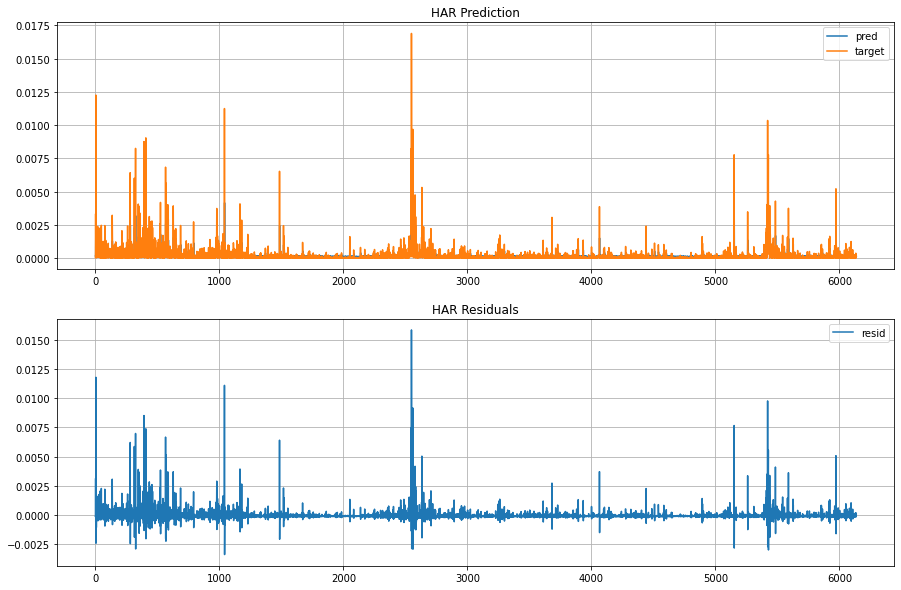

Estimating NN model ...
NN out-of-sample loss: 3.81152574391308e-07
Predicted correlation: 0.2448394902352142


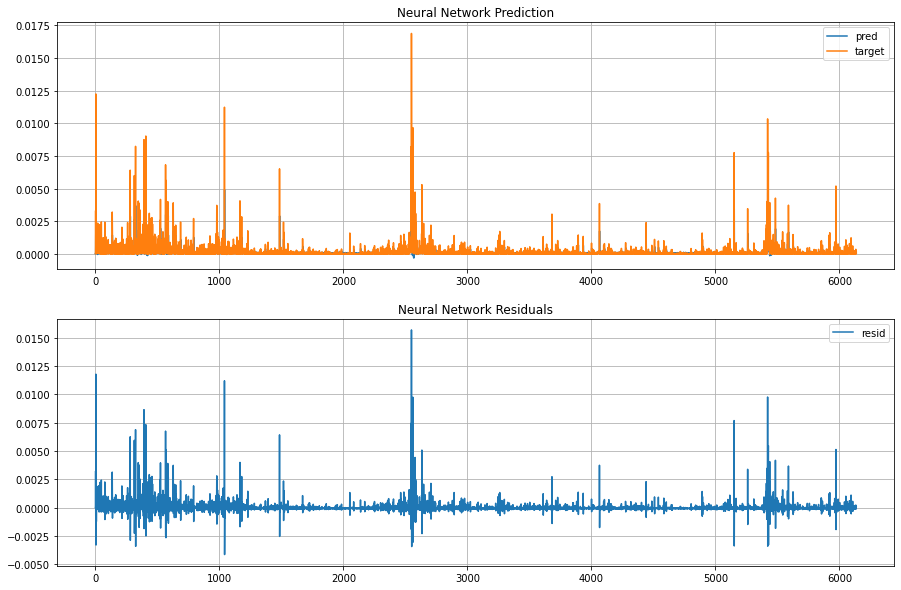

In [91]:
plot = True
normalize_features = False

# if the params are not set through cross validations above
if not (epochs and hidden_nodes and lr):
    print("No params from cross validation, using own params instead")
    epochs = 10
    hidden_nodes = 5
    lr = .01
    
note = f"Estimating HAR and NN for fold: {i}"
print_nicely(note, 100)

# the available features
features_har, features, targets # to train on
features_har_validation, features_validation ,targets_validation # to validate on

# fit normalizer on train features and normalize data
print("Normalizing features ...")

if normalize_features:
    scaler = StandardScaler()
    features_transformed = scaler.fit_transform(features)
    features_validation_transformed = scaler.transform(features_validation)
    features_har_transformed = scaler.fit_transform(features_har)
    features_har_validation_transformed = scaler.transform(features_har_validation)
else:
    features_transformed = features
    features_validation_transformed = features_validation
    features_har_transformed = features_har
    features_har_validation_transformed = features_har_validation

#=========================================================================================
#===================================ESTIMATE HAR==========================================
#=========================================================================================
print("Estimating HAR model ...")
HAR = OLS(targets, features_har_transformed, hasconst = True)
HAR = HAR.fit()
output = HAR.predict(features_har_validation_transformed)

loss = np.var(targets_validation - output)
score_har = loss

print(f"HAR out-of-sample loss: {loss}")
print(f"Predicted correlation: {np.corrcoef(output, targets_validation.reshape(-1,))[0,1]}")

if plot:        
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15, 10))
    axs[0].set_title("HAR Prediction")
    axs[1].set_title("HAR Residuals")
    axs[0].plot(output, label = "pred")
    axs[0].plot(targets_validation, label = "target")
    axs[1].plot(targets_validation.reshape(-1,) - output, label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#====================================ESTIMATE NN==========================================
#=========================================================================================

# all features and targets to float tensor
features_train_tensor = torch.tensor(features_transformed, dtype=torch.float32)
features_test_tensor = torch.tensor(features_validation_transformed, dtype=torch.float32)
targets_train_tensor = torch.tensor(targets, dtype=torch.float32)
targets_test_tensor = torch.tensor(targets_validation, dtype=torch.float32)

trainloader, testloader = data_to_loaders(features_train_tensor, features_test_tensor, targets_train_tensor, targets_test_tensor)
        
# initialize and estimate the model
print("Estimating NN model ...")
model = RegularNN(features.shape[1], hidden_nodes, targets.shape[1])
criterion = nn.MSELoss()

loss = model_estimator(
    model,
    optimizer = optim.Adam(model.parameters(), lr = lr), 
    criterion = criterion, 
    epochs=epochs,
    trainloader=trainloader, 
    testloader=testloader,
    earlystopper=None)

# perform out of sample prediction
output = model(features_test_tensor)
loss = criterion(output, targets_test_tensor)
score_nn = loss.item()

print(f"NN out-of-sample loss: {loss}")
print(f"Predicted correlation: {np.corrcoef(targets_test_tensor.detach().numpy()[:,0], output.detach().numpy()[:,0])[0,1]}")

if plot:
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15,10))
    axs[0].set_title("Neural Network Prediction")
    axs[1].set_title("Neural Network Residuals")
    axs[0].plot(output.detach().numpy(), label = "pred")
    axs[0].plot(targets_test_tensor.detach().numpy(), label = "target")
    axs[1].plot(targets_test_tensor.detach().numpy() - output.detach().numpy(), label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#=========================================================================================
#=========================================================================================